In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
workDir = '/home/chantal/Chazy/Bulk/ITS/data/'
figDir = '/home/chantal/Chazy/Bulk/ITS/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/ITS/'
physeqBulk = 'bulk-core'


nprocs = 20

In [3]:
%%R
library(phyloseq)
library(tidyr)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

#### Read in sample metadata and OTU table

In [4]:
%%R

F = file.path(physeqDir, physeqBulk)
print(F)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS"),
                           physeq.Bulk)

physeq.Bulk = subset_taxa(physeq.Bulk, Rank1=="k__Fungi")

physeq.Bulk.m = physeq.Bulk %>% sample_data


physeq.Bulk

[1] "/home/chantal/Chazy/data/phyloseq/ITS//bulk-core"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2247 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2247 taxa by 7 taxonomic ranks ]


In [5]:
%%R
get_l2fc = function(physeq.obj, sparsity_threshold) {
    physeq.md = sample_data(physeq.obj)
   
    p = filter_taxa(physeq.obj, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
 
    dds = phyloseq_to_deseq2(p, ~ OM)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
        
    theta = 1
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
   
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "padj")])

   # d$padj = p.adjust(p, method = "BH")
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)


    d
}

In [6]:
%%R
# adding range of sparsity thresholds (all pairwise)

sdms = as.data.frame(seq(0.05,0.95,0.05))
colnames(sdms) = 'sparsity_threshold'
#cat('Number of pairwise combinations of variables:', sdms.P %>% nrow, '\n\n')
head(sdms) 

  sparsity_threshold
1               0.05
2               0.10
3               0.15
4               0.20
5               0.25
6               0.30


In [7]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(sdms, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq.Bulk))
df.l2fc

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:1

Source: local data frame [3,648 x 12]

   sparsity_threshold       OTU log2FoldChange     lfcSE       padj    Rank1
                (dbl)     (chr)          (dbl)     (dbl)      (dbl)   (fctr)
1                0.05  OTU.6089     -0.9801378 0.9119983 0.50781558 k__Fungi
2                0.05  OTU.6711      0.6570815 0.7369292 0.59694046 k__Fungi
3                0.05  OTU.2605      1.6193454 0.5401458 0.01669164 k__Fungi
4                0.05  OTU.6041     -0.6267623 0.9067649 0.68446191 k__Fungi
5                0.05  OTU.6291     -1.2644476 0.6806101 0.17776689 k__Fungi
6                0.05  OTU.9364      1.3375805 0.7832460 0.22647875 k__Fungi
7                0.05   OTU.586     -0.4340885 0.5620721 0.64826304 k__Fungi
8                0.05 OTU.19007      2.2442225 0.9865778 0.08446260 k__Fungi
9                0.05   OTU.469      0.7501262 0.9728651 0.64826304 k__Fungi
10               0.05 OTU.28809      0.4027933 0.9885477 0.79782152 k__Fungi
..                ...       ...      

In [8]:
%%R
summarise(df.l2fc,
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

   meanl2fc
      (dbl)
1 0.5533476


In [9]:
%%R
summarise(df.l2fc,
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    sdl2fc
     (dbl)
1 1.168188


In [10]:
%%R
levels(physeq.Bulk.m$OM)

[1] "H" "R"


In [11]:
%%R
df.l2fc$padj2 = p.adjust(df.l2fc$padj, method = "BH")

In [12]:
%%R
df.l2fc$OM[df.l2fc$log2FoldChange > 0] = "Returned"
df.l2fc$OM[df.l2fc$log2FoldChange < 0] = "Harvested"

In [13]:
%%R
write.csv(df.l2fc, 'data/LFC_OM_prefilt.csv')

In [21]:
%%R
df.l2fc = read.csv('data/LFC_OM_prefilt.csv')
head(df.l2fc)

  X sparsity_threshold      OTU log2FoldChange     lfcSE       padj    Rank1
1 1               0.05 OTU.6089     -0.9801378 0.9119983 0.50781558 k__Fungi
2 2               0.05 OTU.6711      0.6570815 0.7369292 0.59694046 k__Fungi
3 3               0.05 OTU.2605      1.6193454 0.5401458 0.01669164 k__Fungi
4 4               0.05 OTU.6041     -0.6267623 0.9067649 0.68446191 k__Fungi
5 5               0.05 OTU.6291     -1.2644476 0.6806101 0.17776689 k__Fungi
6 6               0.05 OTU.9364      1.3375805 0.7832460 0.22647875 k__Fungi
             Rank2             Rank3           Rank4           Rank5
1  p__unidentified   c__unidentified o__unidentified f__unidentified
2  p__unidentified   c__unidentified o__unidentified f__unidentified
3  p__unidentified   c__unidentified o__unidentified f__unidentified
4 p__Basidiomycota c__Agaricomycetes   o__Agaricales  f__Agaricaceae
5 p__Basidiomycota c__Agaricomycetes   o__Agaricales  f__Agaricaceae
6 p__Basidiomycota c__Agaricomycetes    o__Bole

In [22]:
%%R
r = filter(df.l2fc, padj2 <=0.10)
length(unique(r$OTU))

[1] 174


In [23]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH = df.l2fc %>%
    filter(padj2 <= padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH %>% head(n=6)

Source: local data frame [6 x 2]

  sparsity_threshold n_reject_hypo
               (dbl)         (int)
1               0.05           149
2               0.10           156
3               0.15           141
4               0.20           123
5               0.25            95
6               0.30            85


In [17]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH.s = df.l2fc %>%
    filter(padj2 < padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH.s %>% as.data.frame

   sparsity_threshold n_reject_hypo
1                0.05           149
2                0.10           156
3                0.15           141
4                0.20           123
5                0.25            95
6                0.30            85
7                0.35            74
8                0.40            67
9                0.45            63
10               0.50            57
11               0.55            54
12               0.60            49
13               0.65            45
14               0.70            44
15               0.75            40
16               0.80            36
17               0.85            29
18               0.90            21
19               0.95            18


In [18]:
%%R
# max number of rejected hypos 
max.rejH = df.l2fc.rejH.s %>%
    arrange(desc(n_reject_hypo)) %>%
    head(n=1)
max.rejH = max.rejH$sparsity_threshold
max.rejH

[1] 0.1


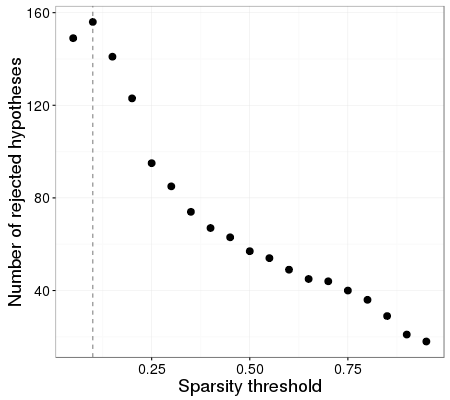

In [19]:
%%R -w 450 -h 400

ggplot(df.l2fc.rejH.s, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(size=3) +
    geom_vline(xintercept=max.rejH, linetype='dashed', alpha=0.5) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        )

In [20]:
%%R
df.l2fc.f = df.l2fc %>%
    filter(sparsity_threshold == 0.05) 

df.l2fc.f %>% nrow

[1] 737


In [21]:
%%R
re = filter(df.l2fc.f, padj2 <=0.10)
length(re$OTU)

[1] 149


In [22]:
%%R
149/737

[1] 0.202171


In [23]:
%%R #-i workDir
# Writing out l2fc table

outFile = 'data/l2fc_sparse-maxRejH_bulk_OM.txt'
write.table(df.l2fc.f, 'data/l2fc_sparse-maxRejH_bulk_OM.txt', sep='\t', quote=FALSE, row.names=FALSE)

In [4]:
%%R
df.l2fc = read.table('data/l2fc_sparse-maxRejH_bulk_OM.txt', sep='\t', header = TRUE)

In [5]:
%%R
df.l2fc$Rank2 = gsub("p__", "", df.l2fc$Rank2)
df.l2fc$Rank3 = gsub("c__", "", df.l2fc$Rank3)
df.l2fc$Rank4 = gsub("o__", "", df.l2fc$Rank4)
df.l2fc$Rank5 = gsub("f__", "", df.l2fc$Rank5)
df.l2fc$Rank6 = gsub("g__", "", df.l2fc$Rank6)
df.l2fc$Rank7 = gsub('s__', "", df.l2fc$Rank7)

In [6]:
%%R
print(length(df.l2fc$OTU))
print(length(unique(df.l2fc$OTU)))

[1] 737
[1] 737


In [7]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.10) %>% group_by(OM) %>% summarise(resp = n())
resp %>% as.data.frame

         OM resp
1 Harvested   23
2  Returned  126


In [8]:
%%R
df.l2fc %>% filter(padj2 <=0.10) %>% group_by(Rank6, OM) %>% summarise(resp = n()) %>% ungroup %>% arrange(-resp) %>%
         as.data.frame

            Rank6        OM resp
1            <NA>  Returned   39
2    unidentified  Returned   31
3    unidentified Harvested    8
4            <NA> Harvested    7
5    Cryptococcus  Returned    4
6     Trichoderma  Returned    4
7         Candida  Returned    3
8     Penicillium  Returned    3
9      Acremonium Harvested    2
10  Articulospora  Returned    2
11       Fusarium  Returned    2
12    Ilyonectria  Returned    2
13  Monographella  Returned    2
14    Mortierella Harvested    2
15    Mortierella  Returned    2
16        Phallus  Returned    2
17    Psathyrella  Returned    2
18  Schizothecium  Returned    2
19     Acremonium  Returned    1
20     Auxarthron Harvested    1
21      Beauveria Harvested    1
22     Cercophora  Returned    1
23     Chaetomium  Returned    1
24    Coniochaeta  Returned    1
25    Coprinellus Harvested    1
26    Coprinopsis  Returned    1
27      Diaporthe  Returned    1
28      Dioszegia  Returned    1
29      Exophiala  Returned    1
30     Gue

In [9]:
%%R
test = matrix(c(23, 714, 126, 611), nrow =2, ncol = 2)
colnames(test) = c('H', 'R')
rownames(test) = c('responders', 'non-responders')
test

                 H   R
responders      23 126
non-responders 714 611


In [10]:
%%R
test2 = fisher.test(test)
str(test2)

data.frame(test2$p.value, '12C', 'Day3')

List of 7
 $ p.value    : num 3.95e-20
 $ conf.int   : atomic [1:2] 0.0944 0.249
  ..- attr(*, "conf.level")= num 0.95
 $ estimate   : Named num 0.156
  ..- attr(*, "names")= chr "odds ratio"
 $ null.value : Named num 1
  ..- attr(*, "names")= chr "odds ratio"
 $ alternative: chr "two.sided"
 $ method     : chr "Fisher's Exact Test for Count Data"
 $ data.name  : chr "test"
 - attr(*, "class")= chr "htest"
  test2.p.value X.12C. X.Day3.
1  3.953839e-20    12C    Day3


In [11]:
%%R
df.P = df.l2fc %>% group_by(Rank2) %>% mutate(ntax = n()) %>% filter(padj2 <= 0.10) %>% mutate(resp = n()) 
head(df.P)

Source: local data frame [6 x 17]
Groups: Rank2 [3]

      X sparsity_threshold      OTU log2FoldChange     lfcSE         padj
  (int)              (dbl)   (fctr)          (dbl)     (dbl)        (dbl)
1     3               0.05 OTU.2605       1.619345 0.5401458 1.669164e-02
2    15               0.05  OTU.133       1.215584 0.2241650 1.730453e-06
3    20               0.05 OTU.4807       2.748352 0.6402075 2.406814e-04
4    23               0.05 OTU.1259       2.318270 0.6205270 1.914083e-03
5    30               0.05 OTU.2583      -3.648637 0.7369823 1.516733e-05
6    39               0.05 OTU.1434       1.278678 0.3720961 4.881259e-03
Variables not shown: Rank1 (fctr), Rank2 (chr), Rank3 (chr), Rank4 (chr), Rank5
  (chr), Rank6 (chr), Rank7 (chr), padj2 (dbl), OM (fctr), ntax (int), resp
  (int)


In [12]:
%%R
df.P2 = df.P %>% ungroup %>% select(Rank2, ntax, resp) %>% unique() 
df.P2$Perc_resp = df.P2$resp/df.P2$ntax

df.P2 %>% arrange(Rank2)

Source: local data frame [7 x 4]

               Rank2  ntax  resp Perc_resp
               (chr) (int) (int)     (dbl)
1         Ascomycota   495   116 0.2343434
2      Basidiomycota   114    17 0.1491228
3 Blastocladiomycota     1     1 1.0000000
4      Rozellomycota     6     2 0.3333333
5       unidentified    49     5 0.1020408
6         Zygomycota    30     5 0.1666667
7                 NA    14     3 0.2142857


In [13]:
%%R
df.P2 = df.P %>% ungroup %>% select(Rank2, ntax, resp) %>% unique() 
df.P2$Perc_respoftotal = df.P2$resp/sum(df.P2$resp)

df.P2 %>% arrange(Rank2)

Source: local data frame [7 x 4]

               Rank2  ntax  resp Perc_respoftotal
               (chr) (int) (int)            (dbl)
1         Ascomycota   495   116      0.778523490
2      Basidiomycota   114    17      0.114093960
3 Blastocladiomycota     1     1      0.006711409
4      Rozellomycota     6     2      0.013422819
5       unidentified    49     5      0.033557047
6         Zygomycota    30     5      0.033557047
7                 NA    14     3      0.020134228


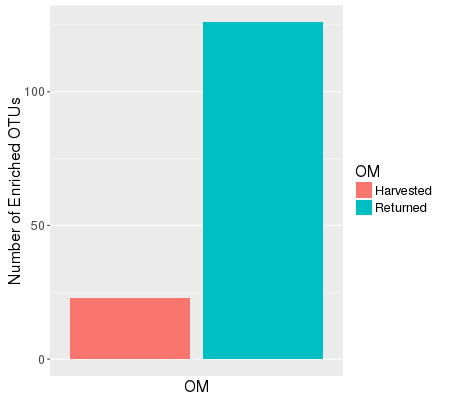

In [14]:
%%R -w 450 -h 400
p = ggplot(data = resp, aes(x = OM, y = resp, fill = OM)) +
    geom_bar(stat = 'identity') + 
    theme(text = element_text(size=16)) + ylab("Number of Enriched OTUs") + scale_x_discrete(breaks=NULL)
p

In [15]:
%%R
ggsave(filename = "data/figs/EnrichedNumoverTime_OM.jpg", plot = p, width =4, height =5)

In [16]:
%%R
colors.1 = c("#6d7000",
"#0258dd",
"#37a411",
"#8163ed",
"#c1ab00",
"#017de1",
"#ffa43a",
"#ff8aff",
"#009b4d",
"#fd47b8",
"#00a272",
"#f92b5d",
"#65dab9",
"#a90614",
"#01a0bd",
"#f36026",
"#8e6794",
"#c5cb8b",
"#a30a4b",
"#c3a573",
"#7c3c6e",
"#ff6167",
"#925349",
"#ff8aa5",
"#8c3913")

####Function arguments

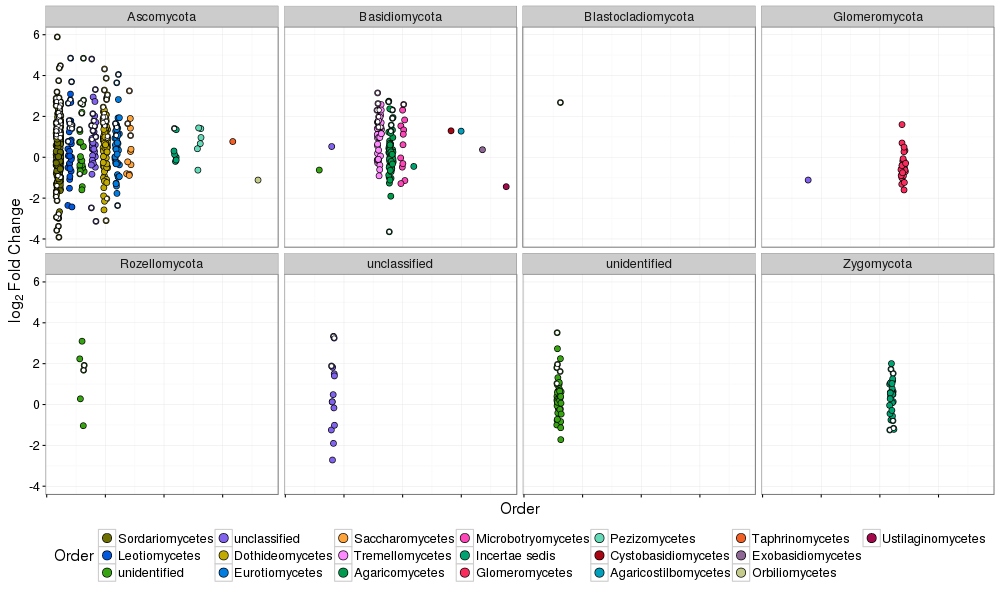

In [25]:
%%R -w 1000 -h 600
d = df.l2fc
FDR = 0.10

d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank3= factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank3 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank3))

p = p + geom_point(alpha = 1.00, shape = 21, size = 2.5)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "white", shape = 21, size = 1.75)

#p = p + geom_hline(y = 1.3)


p = p + theme_bw() + theme(axis.text.x = element_blank())

p = p + labs(x = "Order", fill = "Order")


p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(fill = guide_legend(override.aes = list(size=4), nrow = 3))  +
    theme(text = element_text(size=16)) #+ guides(color = FALSE)

p = p + facet_wrap(~Rank2, ncol = 4) +
    theme(legend.position = 'bottom')

p

In [26]:
%%R
ggsave('data/figs/OM_phylaLFC.jpg', width = 14, height = 8)

In [18]:
%%R
df.P = df.l2fc %>% group_by(Rank2,OM) %>% mutate(ntax = n()) %>% filter(padj2 <= 0.10) %>% mutate(resp = n()) 
head(df.P)

Source: local data frame [6 x 17]
Groups: Rank2, OM [4]

      X sparsity_threshold      OTU log2FoldChange     lfcSE         padj
  (int)              (dbl)   (fctr)          (dbl)     (dbl)        (dbl)
1     3               0.05 OTU.2605       1.619345 0.5401458 1.669164e-02
2    15               0.05  OTU.133       1.215584 0.2241650 1.730453e-06
3    20               0.05 OTU.4807       2.748352 0.6402075 2.406814e-04
4    23               0.05 OTU.1259       2.318270 0.6205270 1.914083e-03
5    30               0.05 OTU.2583      -3.648637 0.7369823 1.516733e-05
6    39               0.05 OTU.1434       1.278678 0.3720961 4.881259e-03
Variables not shown: Rank1 (fctr), Rank2 (chr), Rank3 (chr), Rank4 (chr), Rank5
  (chr), Rank6 (chr), Rank7 (chr), padj2 (dbl), OM (fctr), ntax (int), resp
  (int)


In [19]:
%%R
df.P2 = df.P %>% ungroup %>% select(Rank2, ntax, resp, OM) %>% unique() 
df.P2$Perc_resp = df.P2$resp/df.P2$ntax

df.P2 %>% arrange(Rank2)

Source: local data frame [10 x 5]

                Rank2  ntax  resp        OM  Perc_resp
                (chr) (int) (int)    (fctr)      (dbl)
1          Ascomycota   317    97  Returned 0.30599369
2          Ascomycota   178    19 Harvested 0.10674157
3       Basidiomycota    73    16  Returned 0.21917808
4       Basidiomycota    41     1 Harvested 0.02439024
5  Blastocladiomycota     1     1  Returned 1.00000000
6       Rozellomycota     5     2  Returned 0.40000000
7        unidentified    30     5  Returned 0.16666667
8          Zygomycota     9     3 Harvested 0.33333333
9          Zygomycota    21     2  Returned 0.09523810
10                 NA     9     3  Returned 0.33333333


In [20]:
%%R
df.P2 = df.P %>% ungroup %>% select(Rank2, ntax, resp) %>% unique() 
df.P2$Perc_respoftotal = df.P2$resp/sum(df.P2$resp)

df.P2 %>% arrange(Rank2)

Source: local data frame [10 x 4]

                Rank2  ntax  resp Perc_respoftotal
                (chr) (int) (int)            (dbl)
1          Ascomycota   317    97      0.651006711
2          Ascomycota   178    19      0.127516779
3       Basidiomycota    73    16      0.107382550
4       Basidiomycota    41     1      0.006711409
5  Blastocladiomycota     1     1      0.006711409
6       Rozellomycota     5     2      0.013422819
7        unidentified    30     5      0.033557047
8          Zygomycota     9     3      0.020134228
9          Zygomycota    21     2      0.013422819
10                 NA     9     3      0.020134228


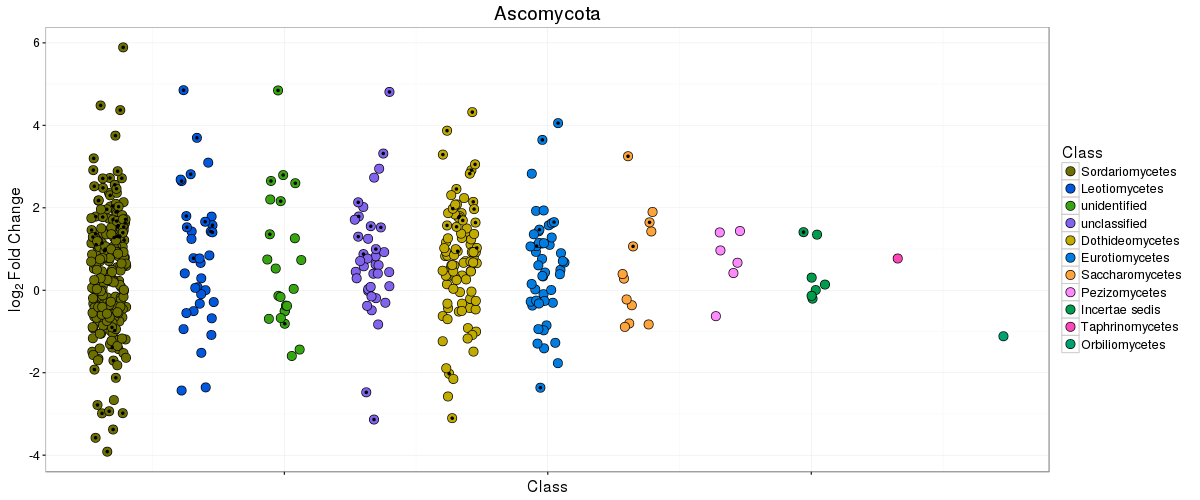

In [21]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Ascomycota')
d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank3 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank3))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", fill = "Class")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle('Ascomycota')


p

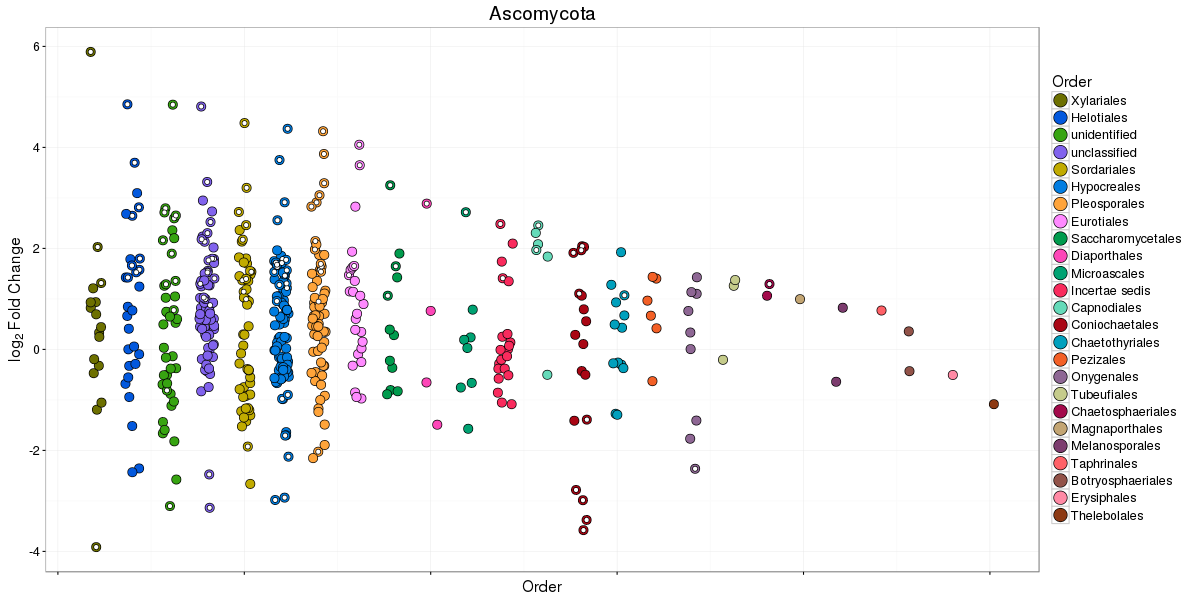

In [27]:
%%R -w 1200 -h 600
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Ascomycota')
d$Rank4 = as.character(d$Rank4)
d$Rank4[is.na(d$Rank4)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank4)

max.l2fc = ddply(d, .(Rank4), summarize, M = max(log2FoldChange))
d$Rank4 = factor(d$Rank4, max.l2fc[order(-max.l2fc$M),]$Rank4)

M = max(as.numeric(d$Rank4), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank4)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank4))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "white", shape = 21, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Order", fill = "Order")


p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(fill = guide_legend(override.aes = list(size=6), ncol = 1))  +
    theme(text = element_text(size=16)) + ggtitle('Ascomycota')


p

In [28]:
%%R
ggsave(filename = "data/figs/OM_OTUs_Ascos.jpg", plot = p, width =12, height =8)

In [24]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Ascomycota')
d$Rank5 = as.character(d$Rank5)
d$Rank5[is.na(d$Rank5)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank5= factor(d$Rank5)

max.l2fc = ddply(d, .(Rank5), summarize, M = max(log2FoldChange))
d$Rank4 = factor(d$Rank5, max.l2fc[order(-max.l2fc$M),]$Rank5)

M = max(as.numeric(d$Rank5), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank5)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank5))

p = p + geom_point(alpha = .8, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Family", fill = "Family")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle('Ascomycota') 



p

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error: Insufficient values in manual scale. 54 needed but only 25 provided.

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning message:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: replacing previous import ‘BiocGenerics::Position’ by ‘ggplot2::Position’ when loading ‘phyloseq’ 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


RRuntimeError: Error: Insufficient values in manual scale. 54 needed but only 25 provided.


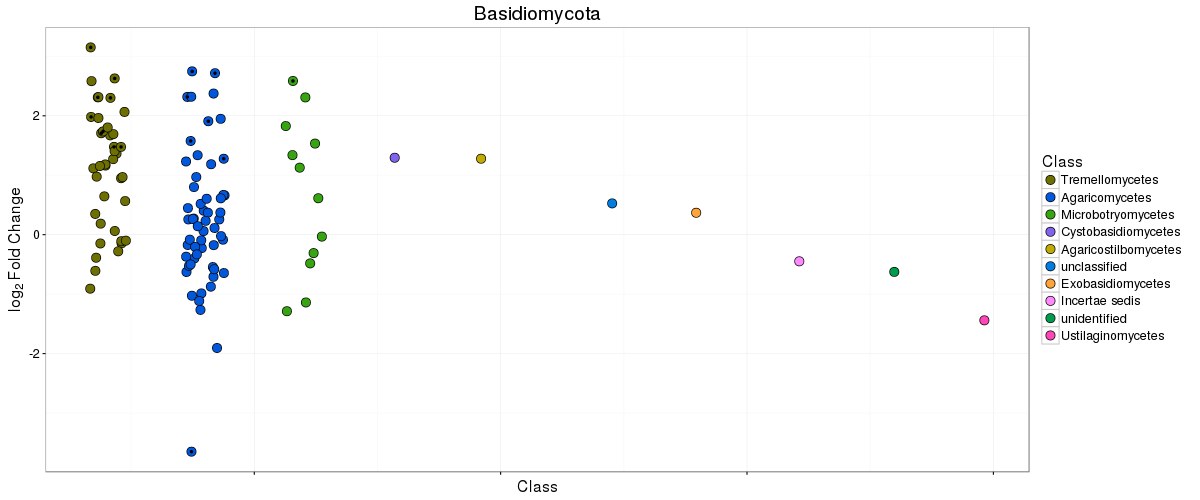

In [29]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Basidiomycota')
d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank3 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank3))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", fill = "Class")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle('Basidiomycota')


p

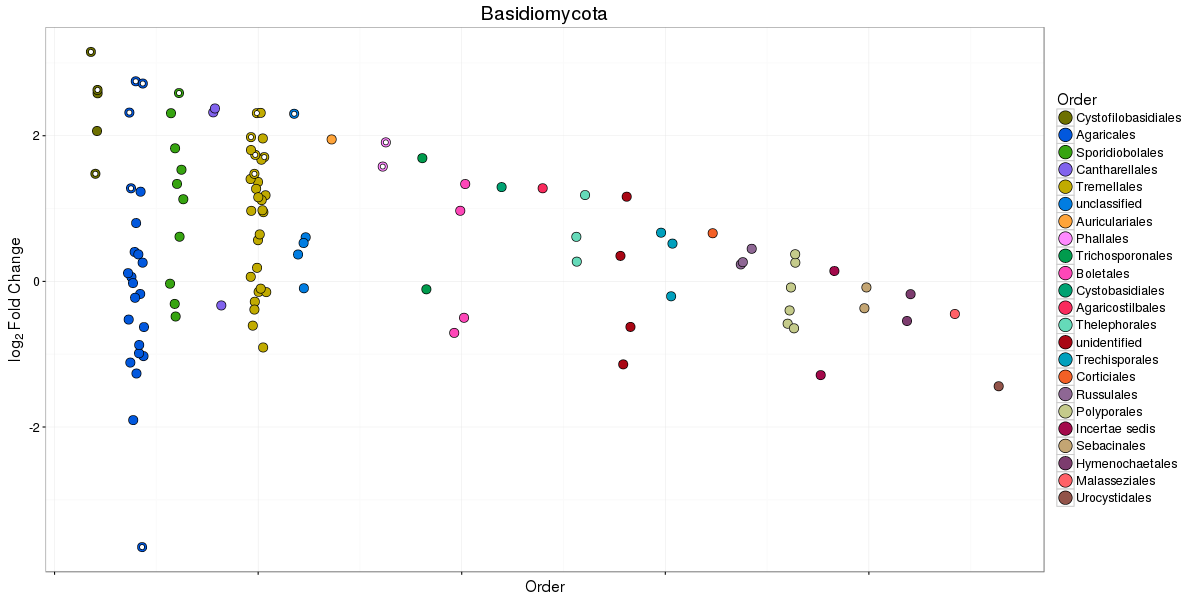

In [31]:
%%R -w 1200 -h 600
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Basidiomycota')
d$Rank4 = as.character(d$Rank4)
d$Rank4[is.na(d$Rank4)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank4)

max.l2fc = ddply(d, .(Rank4), summarize, M = max(log2FoldChange))
d$Rank4 = factor(d$Rank4, max.l2fc[order(-max.l2fc$M),]$Rank4)

M = max(as.numeric(d$Rank4), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank4)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank4))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "white", shape = 21, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Order", fill = "Order")


p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(fill = guide_legend(override.aes = list(size= 6), ncol = 1))  +
    theme(text = element_text(size=16)) + ggtitle('Basidiomycota')


p

In [33]:
%%R
ggsave(filename = "data/figs/OM_OTUs_Basidios.jpg", plot = p, width =12, height =8)

In [ ]:
%%R
new_df.l2fc = df.l2fc
new_df.l2fc$Resp_status[new_df.l2fc$padj2 > 0.10] = "non-responder"
new_df.l2fc$Resp_status[new_df.l2fc$padj2 <= 0.10 & new_df.l2fc$log2FoldChange < 0] = 'Harvested'
new_df.l2fc$Resp_status[new_df.l2fc$padj2 <= 0.10 &  new_df.l2fc$log2FoldChange > 0] = "Returned"

In [ ]:
%%R -w 1200 -h 1200
dcounts = new_df.l2fc %>%
          #filter(!is.na(log2FoldChange)) %>%
          #filter(!is.na(padj)) %>%
          filter(Resp_status %in% c("Harvested", "Returned")) %>%
          group_by(Rank6, Rank5, Rank4, Rank3, Rank2, Resp_status) %>%
          summarize(responders = sum(padj2<= 0.10)) %>% ungroup() %>% arrange(Rank4)

dcounts$Rank4[is.na(dcounts$Rank4)] = "Not Annotated"
dcounts$Rank5[is.na(dcounts$Rank5)] = "Not Annotated"
#dcounts$Rank3 = reorder(dcounts$Rank3, -dcounts$responders)
#newrow = c("__Firmicutes", "October", "PT enriched", as.numeric(0))
#dcounts = rbind(dcounts,newrow)
#newrow = c("__Armatimonadetes", "October", "PT enriched", 0)
#dcounts = rbind(dcounts,newrow)
#newrow = c("__Armatimonadetes", "November", "PT enriched", 0)
#dcounts = rbind(dcounts,newrow)
#newrow = c("__Cyanobacteria", "November", "PT enriched", 0)
#dcounts = rbind(dcounts,newrow)
#dcounts$Rank3 <- droplevels(dcounts$Rank3)
#dcounts$responders= as.numeric(dcounts$responders)
#dcounts$Rank3 = reorder(dcounts$Rank3, -dcounts$responders)

p = ggplot(dcounts, aes(x = Resp_status , y = responders, fill = Rank4)) +
    geom_bar(stat = "identity") + #scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap(~Rank2, scales = "free_y") +
    #scale_y_discrete(limits = (0, 50)) +
    ggtitle("Enriched OTUs") + ylab("Responder Counts")+
    xlab("OM Condition") + guides(fill=guide_legend(title='Order', ncol = 1)) +
    theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) + 
    scale_fill_manual(values = colors.1) 

p

In [ ]:
%%R
dcounts%>% group_by(Rank4, Resp_status, Rank2) %>% select(Rank4, Rank2, responders, Resp_status) %>% 
                summarise(totresp = sum(responders)) %>% ungroup %>% arrange(Rank2) %>% as.data.frame

In [ ]:
%%R
ggsave(filename = "data/figs/OMEnriched_byOrder.jpg", plot = p, width =14, height =14)

In [ ]:
%%R -w 1200 -h 600
Resp.to.keep = new_df.l2fc %>% group_by(Rank2, Resp_status) %>% summarise(Resp = sum(padj2<= 0.10)) %>% filter(Resp > 2)

dcounts.filt = filter(dcounts, Rank2 %in% Resp.to.keep$Rank2)

dcounts.filt$Rank3 = reorder(dcounts.filt$Rank3, -dcounts.filt$responders)
dcounts.filt$Rank2 = reorder(dcounts.filt$Rank2, -dcounts.filt$responders)


p = ggplot(dcounts.filt, aes(x = Resp_status , y = responders, fill = Rank4)) +
    geom_bar(stat = "identity") + #scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap(~Rank2, scales = "free_y") +
    #scale_y_discrete(limits = (0, 50)) +
    ggtitle("Enriched OTUs") + ylab("Responder Counts")+
   xlab("Organic Matter Condition") + guides(fill=guide_legend(title='Order', ncol = 1)) +
    theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) +#, legend.position=c(2, 0.2)) +
    scale_fill_manual(values = colors.1)



p

In [ ]:
%%R
ggsave(filename = "data/figs/OMEnriched_byOrder_filt.jpg", plot = p, width =18, height =14)